# Modelos de clasificación

Nicole Lastra Quiroz - Agosto 2022

----------

## Importación de librerías

In [1]:
# Para tratamiento de los datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import multiprocessing

# Para gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns


#Para preprocesado y modelado
# ------------------------------------------------------------------------------
from pandas.core.series import Series
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from pandas.core.series import Series
from sklearn.datasets import load_boston
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

# Para configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

## Importación de datos

In [2]:
# Importación de datos:
# ------------------------------------------------------------------------------
alfa = pd.read_excel('Base_de_Datos_completa.xls', sheet_name='Alfareria')  

## Visualización de los datos 

In [3]:
# Visualización de primeras 7 filas:
# ------------------------------------------------------------------------------
alfa.head(7)

,Al,Fe,Mg,Ca,Na,Sitio
0,14.4,7.00,4.30,0.15,0.51,L
1,13.8,7.08,3.43,0.12,0.17,L
2,14.6,7.09,3.88,0.13,0.20,L
3,11.5,6.37,5.64,0.16,0.14,L
4,13.8,7.06,5.34,0.20,0.20,L
5,10.9,6.26,3.47,0.17,0.22,L
6,10.1,4.26,4.26,0.20,0.18,L


In [4]:
# Información de las variables:
# ------------------------------------------------------------------------------
alfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      26 non-null     float64
 1   Fe      26 non-null     float64
 2   Mg      26 non-null     float64
 3   Ca      26 non-null     float64
 4   Na      26 non-null     float64
 5   Sitio   26 non-null     object 
dtypes: float64(5), object(1)
memory usage: 1.3+ KB


**Hallazgos Principales:**
- No existen valores nulos en ninguna de las variables.
- Las variables relativas a elementos químicos son del numéricas.
- La variable `Sitio` es categórica.

In [5]:
# Revisión rápida de datos estadísticos:
# ------------------------------------------------------------------------------
alfa.describe()

,Al,Fe,Mg,Ca,Na
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,14.492308,4.467692,3.141538,0.146538,0.158462
std,2.992647,2.409751,2.179726,0.101230,0.135283
min,10.100000,0.920000,0.530000,0.010000,0.030000
25%,11.950000,1.700000,0.670000,0.060000,0.050000
50%,13.800000,5.465000,3.825000,0.155000,0.150000
75%,17.450000,6.590000,4.502500,0.215000,0.215000
max,20.800000,7.090000,7.230000,0.310000,0.540000


**Hallazgos Principales:**
- Se observa que las escalas de las variables `Ca` y `Na` se encuentran en un rango compatible entre ellas, pero alejados al de las otras, por lo que quizás sería recomendable normalizar los datos previo modelado.

### Gráficas relevantes para el estudio

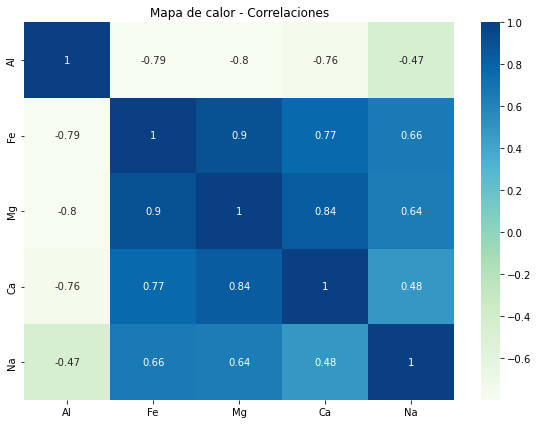

In [6]:
# Mapa de Calor para datos numéricos
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(8,6))

sns.heatmap(alfa.corr(), 
            ax    = ax,
            annot   = True,
            cmap  = 'GnBu'
            )
plt.title('Mapa de calor - Correlaciones')
plt.tight_layout()
plt.show()

**Hallazgos Principales:**
- Se observa una fuerte correlación entre `Mg` y `Fe` (del orden del 90%)
- En general, la mayoría de las variables presentan correlaciones altas (por sobre el 60%), ya sean de caracter directo o inverso
- Sólo en los casos de `Na` y `Al`, así mismo `Na` y `Ca`, se observan correlaciones menores al 50%

Como complemento a la gráfica, se procede a revisar la matriz de correlación numérica para revisar los valores exactos.

In [7]:
# Matriz de correlación de pearson
# ------------------------------------------------------------------------------
alfa.corr()

,Al,Fe,Mg,Ca,Na
Al,1.000000,-0.788822,-0.798397,-0.763528,-0.472595
Fe,-0.788822,1.000000,0.900675,0.765205,0.661684
Mg,-0.798397,0.900675,1.000000,0.841959,0.642723
Ca,-0.763528,0.765205,0.841959,1.000000,0.481533
Na,-0.472595,0.661684,0.642723,0.481533,1.000000


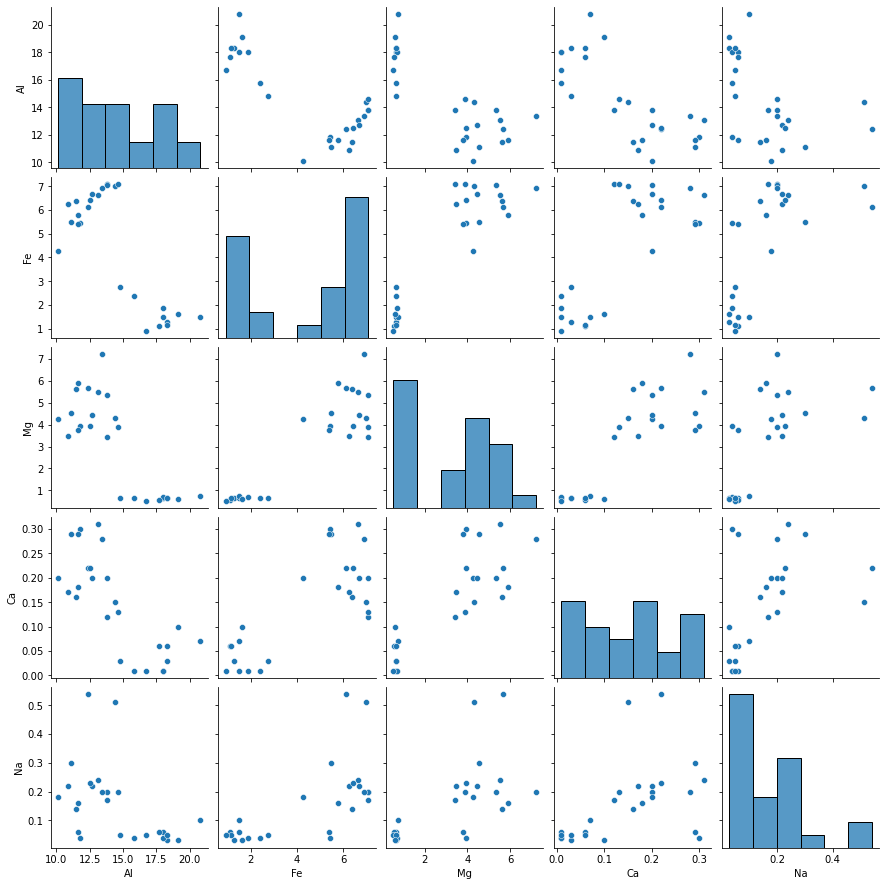

In [8]:
# Gráfico mixto
# ------------------------------------------------------------------------------
sns.pairplot(alfa, height = 2.5)
plt.show()

A continuación se genera una comparativa de boxplots verticales, bajo la misma escala para los diferentes elementos químicos presentes en la data.

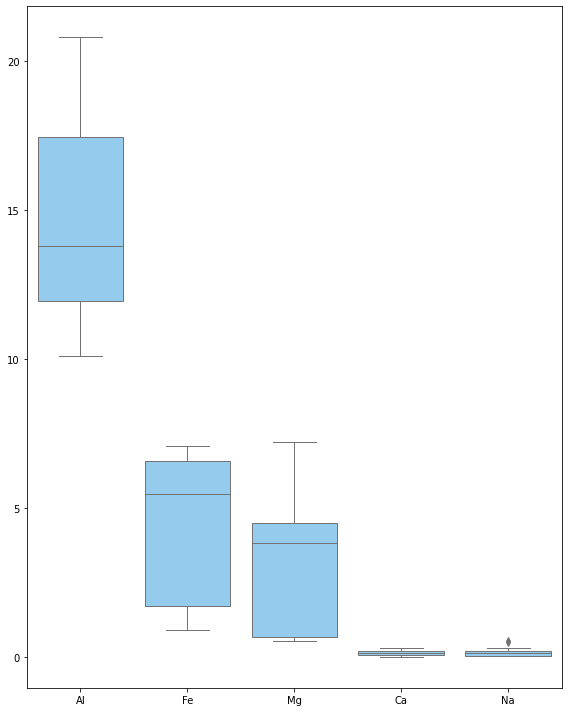

In [9]:
# Comparativa de Boxplots 1
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(8,10))

ax = sns.boxplot (data      = alfa, 
                  orient    = 'v',
                  color     = 'lightskyblue', 
                  linewidth = 1)

plt.tight_layout()
plt.show()

Se observa que los datos se distrubuyen en rangos diferentes entre sí, por lo que se podría pensa en un escalado de variables (aunque al ser una cantidad de datos tan escasa, esto no generaría demasiadas diferencias en los resultados).

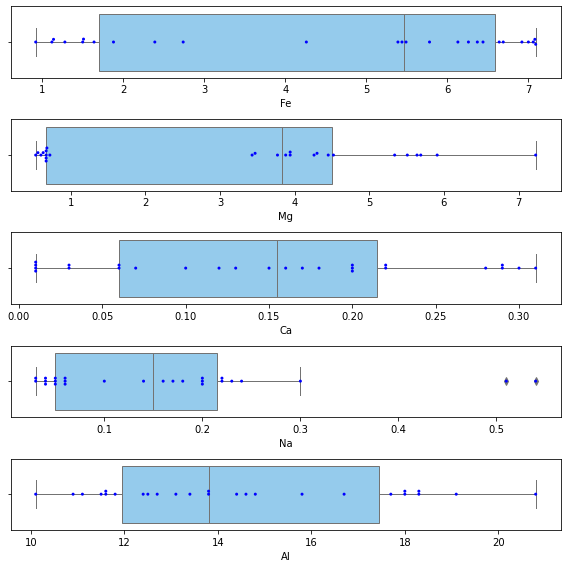

In [10]:
# Boxplots para cada columna numérica
# ------------------------------------------------------------------------------
num   = alfa._get_numeric_data()
names = list(num.columns)
f, axes = plt.subplots(round(len(names)/1), 1, figsize = (8, 8))  
y = 0;
for name in names:
    i, j = divmod((y-1), 1)
    sns.boxplot(
        x         = num[name], 
        ax        = axes[i],
        color     = "lightskyblue",
        linewidth = 1
    )
    
    sns.swarmplot(
        x         = num[name], 
        ax        = axes[i],
        data      = alfa, 
        orient    = 'h', 
        color     = "blue",
        size      = 3,
    )
    y = y + 1
plt.tight_layout()
plt.show()

**Hallazgos principales**
* La variable `Na` posee datos atípicos.
* Los datos de la variable `Mg` no se distribuyen de forma uniforme a lo largo del boxplot.
* El resto de variables se distribuye de forma relativamente uniforme a lo largo del boxplot.

## Limpieza de datos

**_Valores Nulos_**

No existen variables con alto porcentaje de valores nulos, ni tampoco filas, por lo que no se requiere eliminar valores dado este criterio.

**_Datos fuera de rango_**

Dada la baja cantidad de datos que posee la base, estudiar la presencia de valores extremos o atípicos no parece ser una opción que brinde información representativa, por lo que no se eliminaran variables o datos por este criterio. Además, se cuenta con el respaldo de lo visualizado en los boxplots con la distribución de datos, y se debe recordar que sólo uno de los elementos químicos presentó dos datos atípicos.


**_Datos duplicados_**

In [11]:
# Conteo previa eliminación de duplicados
# ------------------------------------------------------------------------------
print('Antes de eliminar duplicados', len(alfa))

# Eliminado de duplicados
# ------------------------------------------------------------------------------
alfa2 = alfa.drop_duplicates()

# Conteo post eliminación de duplicados
# ------------------------------------------------------------------------------
print('Después de eliminar duplicados', len(alfa2))

Antes de eliminar duplicados 26
Después de eliminar duplicados 26


Se concluye que no existen datos duplicados que alteren los resultados del modelo a generar.

**_Recodificación de la variable `Sitio`_**

Debido a que la variable Sitio 

In [12]:
# Recodificación de variables
# ------------------------------------------------------------------------------
alfa2['Sitio'] = alfa2['Sitio'].replace(['L'], 1)
alfa2['Sitio'] = alfa2['Sitio'].replace(['C'], 2)
alfa2['Sitio'] = alfa2['Sitio'].replace(['I'], 3)
alfa2['Sitio'] = alfa2['Sitio'].replace(['A'], 4)
 
# Revisión de los datos
# ------------------------------------------------------------------------------
alfa2.head()

,Al,Fe,Mg,Ca,Na,Sitio
0,14.4,7.00,4.30,0.15,0.51,1
1,13.8,7.08,3.43,0.12,0.17,1
2,14.6,7.09,3.88,0.13,0.20,1
3,11.5,6.37,5.64,0.16,0.14,1
4,13.8,7.06,5.34,0.20,0.20,1


Se revisa la información nuevamente a modo de verificar que el tipo de variable ha cambiado.

In [13]:
# Información de las variables:
# ------------------------------------------------------------------------------
alfa2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      26 non-null     float64
 1   Fe      26 non-null     float64
 2   Mg      26 non-null     float64
 3   Ca      26 non-null     float64
 4   Na      26 non-null     float64
 5   Sitio   26 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 1.4 KB


## Modelado de los datos

### 1.  ANOVA: Verificación de condiciones

#### Independencia 

Se asume independencia de los datos, dados a que han sido entregados para realizar labores de estudio (se asume muestreo aleatorio simple y se validará o descartará según las evidencias encontradas posteriormente).

#### Distribución normal de las observaciones 

Las variable cuantitativas deberían de distribuirse de forma normal en cada uno de las agrupacines dadas, según la columna `Sitio`. 

Este estudio de normalidad podría realizarse de manera gráfica con `qqplot` o con un test de hipótesis, los cuales serán revisados a continuación:

Text(0.5, 1.0, 'Na')

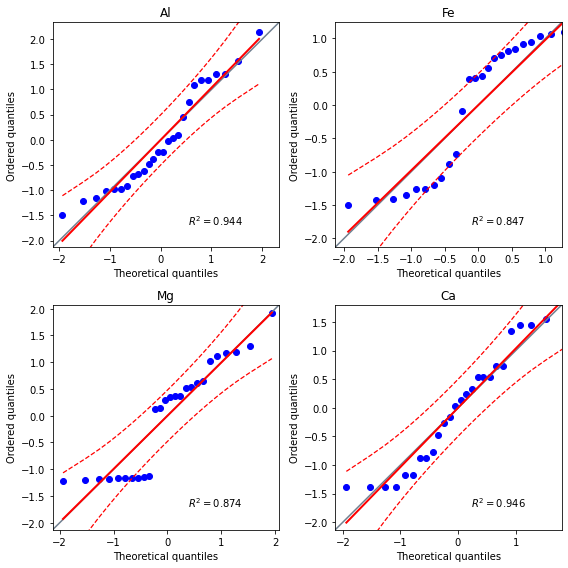

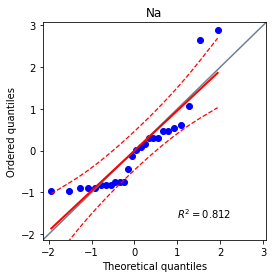

In [14]:
# Quantile - quantile plot para cada uno de lo elementos químicos
# ------------------------------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize = (8, 8))

ax = pg.qqplot(alfa['Al'],
               dist = 'norm',
               ax   = axs[0,0])
axs[0,0].set_title('Al')

ax = pg.qqplot(alfa['Fe'], 
               dist = 'norm', 
               ax   = axs[0,1])
axs[0,1].set_title('Fe')

ax = pg.qqplot(alfa['Mg'], 
               dist = 'norm', 
               ax   = axs[1,0])
axs[1,0].set_title('Mg')

ax = pg.qqplot(alfa['Ca'], 
               dist = 'norm', 
               ax   = axs[1,1])
axs[1,1].set_title('Ca')

plt.tight_layout()

fig, ax1 = plt.subplots(figsize = (4, 4))

ax = pg.qqplot(alfa['Na'], 
               dist = 'norm', 
               ax   = ax1)
ax1.set_title('Na')


Se observan distribuciones de los datos no coincidentes con una normal, de forma más marcada, en el caso de `Fe` y `Mg`, lo mismo en el caso de `Na`, pero se observa que esto podría estar ddado por los dos puntos atípicos que presenta. Sólo `Al` y `Ca` presentan $R^2$ sobre el 0.94.

En este caso no se puede aplicar un test de normalidad de Shapiro-Wilk dado a que se necesitan más de dos muestras, y al hacer el `group` según la columna `Sitio`, se obtienen los siguientes resultados: 

In [15]:
# Número de observaciones por grupo
# ------------------------------------------------------------------------------
alfa.groupby('Sitio').size()

Sitio
A     5
C     2
I     5
L    14
dtype: int64

Como se puede ver, la categoría `C` tiene sólo dos muestras, lo que arruina el estudio. Se podría eliminar dicha categoría y sus datos asociados, para hacer un estudio a los demás grupos, pero dada la baja cantidad de datos, esto es algo que no valdría la pena.

En cambio, si podemos realizar un test de normalidad simple (esta vez por Shapiro), sin realizar una agrupación de los datos.

In [16]:
# Test de normalidad univariada
# ------------------------------------------------------------------------------
print(pg.normality(alfa))


           W      pval  normal
Al  0.933607  0.094467    True
Fe  0.822343  0.000433   False
Mg  0.856937  0.001945   False
Ca  0.923626  0.054717    True
Na  0.813280  0.000299   False


Al complementar esta información con lo obtenido en los datos, se puede apreciar que en el caso de `Na` lo que podría estar afectando su normalidad, son la presencia de los dos datos atípicos ya descubiertos. En el caso de `Mg` y `Fe`, según la gráfica, se puede ver que su distribución podría estar relacionada a otra de características no lineales, pero, nuevamente, al ser tan pocos datos, no se puede afirmar algo en concreto o relevante para el estudio.

#### Varianza constante entre grupos (homocedasticidad) 

Además de la normalidad de los datos, sería necesario revisar la homocedasticidad de ellos (pese a que al encontrar que no todos distribuyen normal, ya descartaría la palicación de un test ANOVA, para efectos de aprendizaje y estudio, se realizará esta parte de igual forma).

In [17]:
# Test de homocedasticidad para cada elemento químico
# ------------------------------------------------------------------------------
print('------------------------------')
print('Test de homocedasticidad de Al')
print('------------------------------')
display(pg.homoscedasticity(data   = alfa, 
                            dv     ='Al', 
                            group  = 'Sitio', 
                            method = 'levene')
       )

print('------------------------------')
print('Test de homocedasticidad de Fe')
print('------------------------------')
display(pg.homoscedasticity(data   = alfa, 
                            dv     ='Al', 
                            group  = 'Sitio', 
                            method = 'levene')
       )

print('------------------------------')
print('Test de homocedasticidad de Mg')
print('------------------------------')
display(pg.homoscedasticity(data   = alfa, 
                            dv     ='Al', 
                            group  = 'Sitio', 
                            method = 'levene')
       )

print('------------------------------')
print('Test de homocedasticidad de Ca')
print('------------------------------')
display(pg.homoscedasticity(data   = alfa, 
                            dv     ='Al', 
                            group  = 'Sitio', 
                            method = 'levene')
       )

print('------------------------------')
print('Test de homocedasticidad de Na')
print('------------------------------')
display(pg.homoscedasticity(data   = alfa, 
                            dv     ='Al', 
                            group  = 'Sitio', 
                            method = 'levene')
       )

------------------------------
Test de homocedasticidad de Al
------------------------------


,W,pval,equal_var
levene,0.757103,0.530105,True


------------------------------
Test de homocedasticidad de Fe
------------------------------


,W,pval,equal_var
levene,0.757103,0.530105,True


------------------------------
Test de homocedasticidad de Mg
------------------------------


,W,pval,equal_var
levene,0.757103,0.530105,True


------------------------------
Test de homocedasticidad de Ca
------------------------------


,W,pval,equal_var
levene,0.757103,0.530105,True


------------------------------
Test de homocedasticidad de Na
------------------------------


,W,pval,equal_var
levene,0.757103,0.530105,True


Según el test de `levene`, se observa que se cumple la homocedasticidad para todas las variables.

#### Test ANOVA

En este caso como no se cumplen las condiciones de normalidad para todo el conjunto de datos, no correspondería generar un test ANOVA.

### 2. Decision Tree Classifier

Se inicia la etapa de modelado a través de un árbol de decisiones.

#### División de los datos en grupos de `train` y `test`

Se debe considerar que esta división de datos se realizará con foco en la variable de estudio: `Sitio`.

In [36]:
# Definiciones auxiliares
# ------------------------------------------------------------------------------
df = alfa2.drop(columns=['Sitio'])
y = alfa2['Sitio']

# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.3, random_state = 123)

#### Creación del modelo

Con la división generada, se procede a la creación del modelo, para lo cual se considerará una `max_depth = 5` y `criterion = gini` de forma inicial y arbitraria, a modo de referencia para comparaciones futuras.

In [37]:
# Creación del modelo inicial
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 2,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo inicial
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=123)

Profundidad del árbol: 2
Número de nodos terminales: 3


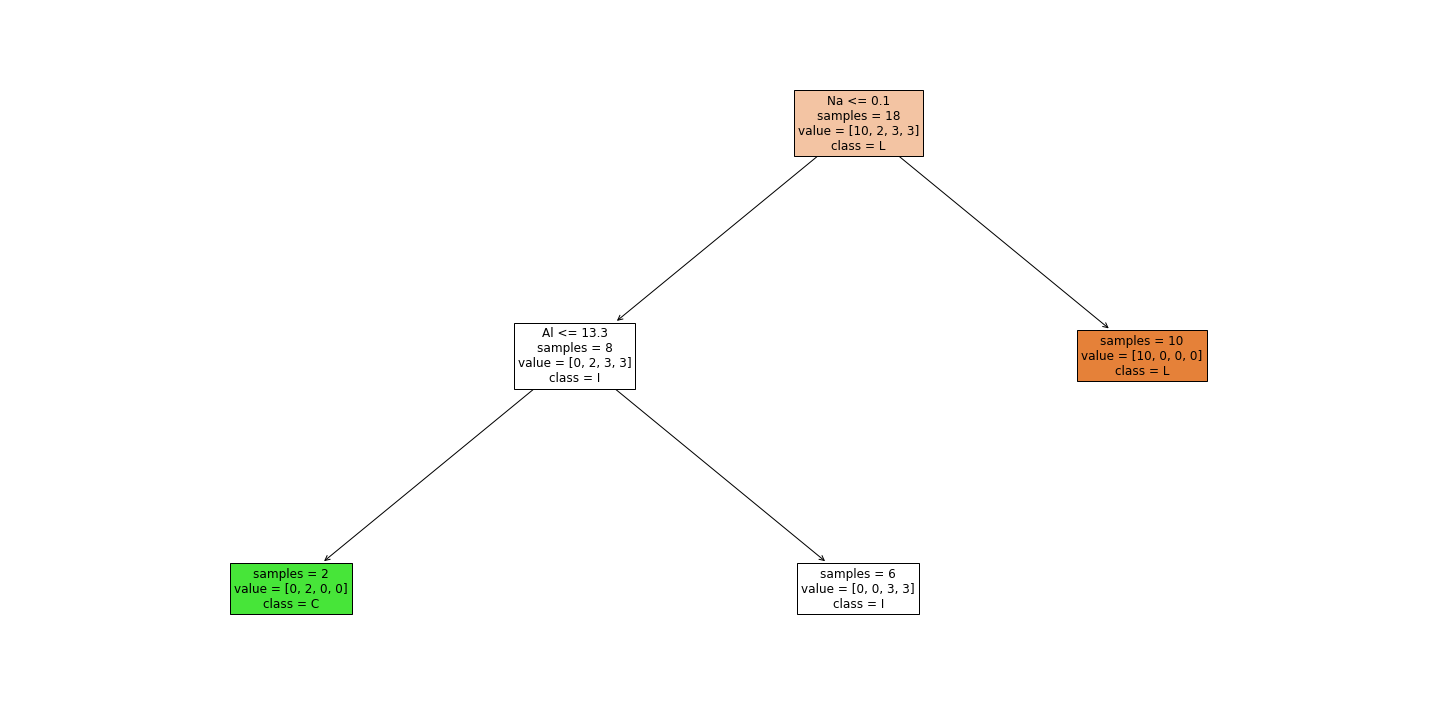

In [38]:
# Visualización de max_depth y nodos terminales
# ------------------------------------------------------------------------------
print(f'Profundidad del árbol: {modelo.get_depth()}')
print(f'Número de nodos terminales: {modelo.get_n_leaves()}')

# Grafica del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(20, 10))

plot = plot_tree(
            decision_tree = modelo,
            feature_names = df.columns.to_list(),
            class_names   = ('L', 'C','I','A'),
            filled        = True,
            impurity      = False,
            fontsize      = 12,
            ax            = ax,
       )

plt.tight_layout()
plt.show()

#### Error y precisión del modelo inicial

Se procede con un estudio del error del modelo inicial, através de la confección de una matriz de confusión, para luego estudiar el `accuracy` del modelo.

In [39]:
# Matriz de confusión del modelo inicial
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test,)

print('Matriz de confusión')
print('-------------------')
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[4, 0, 0],
       [1, 1, 0],
       [0, 2, 0]])

In [40]:
# Precisión del modelo inicial
#-------------------------------------------------------------------------------
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f'El accuracy de test es: {100 * accuracy} %')

El accuracy de test es: 62.5 %


Con la finalidad de mejorar el modelo, se realiza una busqueda de parámetros por validación cruzada.

In [41]:
# Grid de parámetros evaluados
# ------------------------------------------------------------------------------
param_grid = {
              'max_depth'   : range(1,20),
              'max_features': ['sqrt', 'log2'],
              'ccp_alpha'   : range(0,5)
         }

# Búsqueda por validación cruzada
# ------------------------------------------------------------------------------
grid = GridSearchCV(
        
        estimator = DecisionTreeClassifier(
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
      )

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': range(0, 5), 'max_depth': range(1, 20),
                         'max_features': ['sqrt', 'log2']},
             scoring='accuracy')

In [42]:
# Mejores parámetros encontrados
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0, 'max_depth': 4, 'max_features': 'sqrt'}

Profundidad del árbol: 4
Número de nodos terminales: 6


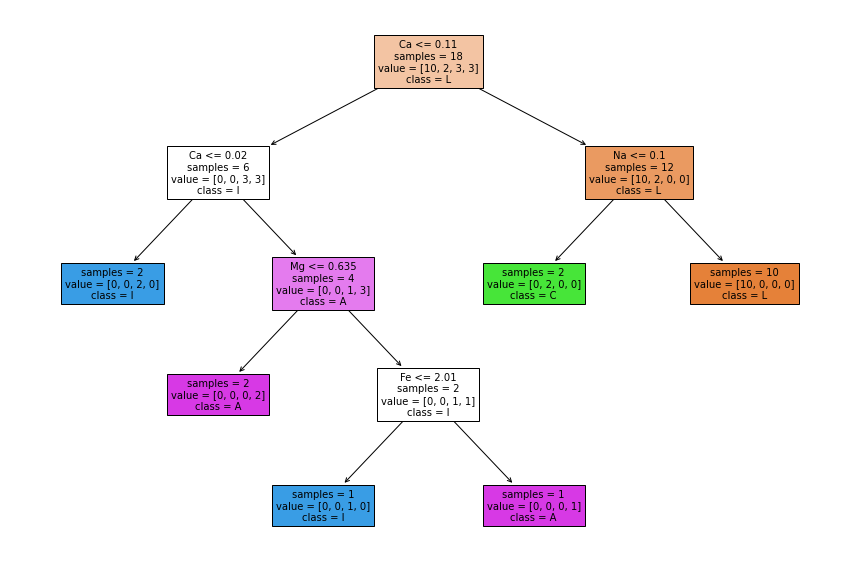

In [43]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_f = grid.best_estimator_
print(f'Profundidad del árbol: {modelo_f.get_depth()}')
print(f'Número de nodos terminales: {modelo_f.get_n_leaves()}')

# Grafica del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize = (12, 8))

plot = plot_tree(
            decision_tree = modelo_f,
            feature_names = df.columns.to_list(),
            class_names   = ('L', 'C','I','A'),
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            ax            = ax
       )

plt.tight_layout()
plt.show()

In [44]:
# Accuracy del modelo final
#-------------------------------------------------------------------------------
predicciones2 = modelo_f.predict(X = X_test)

accuracy2 = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones2,
            normalize = True
           )
print(f'El accuracy de test es: {100 * accuracy2} %')

El accuracy de test es: 75.0 %


Efectivamente se ha logrado mejorar los resultados a un 75% de accuracy, versus el 62,5% del modelo inicial.

Se procede a revisar la importancia de predictores del modelo.

In [45]:
print('Importancia de los predictores en el modelo')
print('-------------------------------------------')
importancia_predictores = pd.DataFrame(
                            {'predictor': df.columns.tolist(),
                             'importancia': modelo_f.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,Ca,0.569307
4,Na,0.297030
1,Fe,0.089109
2,Mg,0.044554
0,Al,0.000000


Los principales predictores que influyen en el modelo son `Ca`, `Na`, y `Fe`.

Se procede a realizar una ronda de 7 predicciones, con sus respectivas probabilidades.

In [46]:
# Predicción de probabilidades para 7 predicciones
#-------------------------------------------------------------------------------
predicciones_p = modelo_f.predict_proba(X = X_test)
predicciones_p[:7, :]

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

### 3. Random Forest

Se realiza un modelado por Random Forest, considerando una busqueda de hiperparámetros por grid search.

In [47]:
# Grid de hiperparámetros evaluados de acuerdo a condiciones preestablecidas
# ------------------------------------------------------------------------------
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [2, 3, 5],
                 'max_depth'   : [None, 5, 10],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ------------------------------------------------------------------------------
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
    )
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")


Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: 

A continuación se revisan los mejores resultados obtenidos.

In [48]:
# Visualización de Resultados
# ------------------------------------------------------------------------------

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head()

,oob_accuracy,criterion,max_depth,max_features,n_estimators
9,0.777778,entropy,NaN,2,150
15,0.777778,entropy,10.0,2,150
12,0.777778,entropy,5.0,2,150
1,0.722222,gini,NaN,3,150
16,0.722222,entropy,10.0,3,150


En la busqueda del mejor modelo, se realiza un grid search con validación cruzada.

In [49]:
# Grid de hiperparámetros evaluados
# ------------------------------------------------------------------------------
param_grid = {'n_estimators': [150],
              'max_features': [3, 5, 7],
              'max_depth'   : [2, 3, 4, 5, 7],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ------------------------------------------------------------------------------
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = RepeatedKFold(n_splits     = 5 , 
                                   n_repeats    = 3, 
                                   random_state = 123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 7],
                         'max_features': [3, 5, 7], 'n_estimators': [150]},
             return_train_score=True, scoring='accuracy')

In [50]:
# Visualización de Resultados
# ------------------------------------------------------------------------------
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
29,entropy,7,7,150,0.655556,0.245075,1.0,0.0
24,entropy,5,3,150,0.655556,0.245075,1.0,0.0
22,entropy,4,5,150,0.655556,0.245075,1.0,0.0
21,entropy,4,3,150,0.655556,0.245075,1.0,0.0
20,entropy,3,7,150,0.655556,0.245075,1.0,0.0


In [51]:
modelo_final = grid.best_estimator_

In [52]:
# Error de test del modelo final
# ------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test)
predicciones[:10]

array([4, 1, 1, 1, 4, 1, 3, 4])

In [53]:
# Matriz de confusión
# ------------------------------------------------------------------------------
mat_confusion = confusion_matrix(
                    y_true = y_test,
                    y_pred = predicciones
                    )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )


print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[4 0 0]
 [0 1 1]
 [0 0 2]]

El accuracy de test es: 87.5 %


Finalmente, el accuracy obtenido es del 87.5%, superando así lo obtenido por modelos anteriores, por lo que se decide optar por el uso de este último modelo.

# Referencias

* PARDO, Mateo. Clustering. Nation Research Council (CNR) , Berlín Alemania, Disponible en: http://lectures.molgen.mpg.de/algsysbio10/clustering.pdf

* Scipy cluster docs https://docs.scipy.org/

* Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026